<a href="https://colab.research.google.com/github/AdityaGaur19/Graph-Algorithms-for-Real-World-Applications/blob/main/Graph_Algorithms_for_Real_World_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💻 Graph Algorithms for Real World Applications
**Course:** Design and Analysis of Algorithms Lab (ENCA351)  
**Session:** 2025-26 | **Program:** BCA (AI & Data Science)  
**Student:** Aditya Singh  
**Faculty:** Dr. Aarti Sangwan  
**Platform:** Google Colab  


In [ ]:
# === Cell 0: Install & imports ===
!pip install -q memory_profiler pandas networkx matplotlib

import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import pandas as pd
import numpy as np
import os
from typing import List, Tuple, Dict, Any

os.makedirs("images", exist_ok=True)
os.makedirs("tables", exist_ok=True)

In [ ]:
# === Cell 0.1: Utilities ===
def mem_and_time(func, *args, **kwargs):
    baseline = memory_usage(proc=-1, interval=0.01, timeout=0.1)
    t0 = time.perf_counter()
    mem = memory_usage((func, args, kwargs), interval=0.01)
    t1 = time.perf_counter()
    peak = max(mem) - (baseline[0] if baseline else 0)
    return {"time": t1 - t0, "mem_mb": peak}

def save_and_show_plot(fig, fname="images/plot.png", dpi=150):
    fig.savefig(fname, bbox_inches="tight", dpi=dpi)
    plt.show()
    print(f"Saved -> {fname}")

def df_to_csv_and_display(df: pd.DataFrame, filename="tables/table.csv"):
    df.to_csv(filename, index=False)
    display(df)
    print(f"Saved -> {filename}")


In [ ]:
# === Cell 1.1: Adjacency List Graph (undirected) ===
class Graph:
    def __init__(self):
        self.adj = {}  # {node: set(neighbors)}

    def add_edge(self, u, v):
        self.adj.setdefault(u, set()).add(v)
        self.adj.setdefault(v, set()).add(u)

    def add_node(self, u):
        self.adj.setdefault(u, set())

    def neighbors(self, u):
        return self.adj.get(u, set())

    def nodes(self):
        return list(self.adj.keys())

    def edges(self):
        seen = set()
        for u, nbrs in self.adj.items():
            for v in nbrs:
                if (v,u) not in seen:
                    seen.add((u,v))
        return list(seen)


In [ ]:
# === Cell 1.2: Friend suggestion using BFS ===
from collections import deque

def suggest_friends_bfs(graph: Graph, user, max_depth=2):
    """
    Return list of suggested friends (friends of friends) not already direct friends.
    BFS up to depth 2; can be extended to higher depth with scoring.
    """
    visited = set([user])
    q = deque([(user, 0)])
    suggestions = {}
    while q:
        node, depth = q.popleft()
        if depth >= max_depth:
            continue
        for nbr in graph.neighbors(node):
            if nbr not in visited:
                visited.add(nbr)
                q.append((nbr, depth + 1))
            # collect friends-of-friends when depth==1 (nbr is a friend)
            if depth == 1 and nbr != user:
                # this branch rarely triggers; alternative approach below
                pass
    # Simpler: collect all nodes at distance == 2
    # Run level-tracking BFS properly

def suggest_friends(graph: Graph, user):
    # Proper level BFS to identify nodes at distance 2
    from collections import deque
    level = {user:0}
    q = deque([user])
    while q:
        u = q.popleft()
        for v in graph.neighbors(u):
            if v not in level:
                level[v] = level[u]+1
                q.append(v)
    # candidates at distance 2
    candidates = [node for node, l in level.items() if l==2]
    # exclude existing friends and user
    suggestions = [c for c in candidates if c not in graph.neighbors(user)]
    return suggestions

Suggested friends for A: ['D', 'F', 'E']


,node,distance,is_friend
0,A,0,False
1,B,1,True
2,C,1,True
3,D,2,False
4,E,2,False
5,F,2,False
6,G,3,False
7,H,3,False
8,I,3,False
9,J,4,False


Saved -> tables/friend_suggestion_table.csv


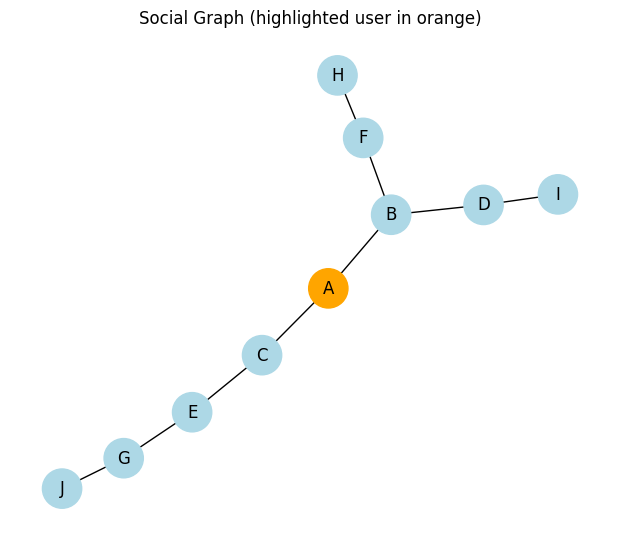

Saved -> images/social_graph.png


In [ ]:
# === Cell 1.3: Example and visualization for friend suggestion ===
g = Graph()
edges = [("A","B"),("A","C"),("B","D"),("C","E"),("B","F"),("E","G"),("F","H"),("D","I"),("G","J")]
for u,v in edges:
    g.add_edge(u,v)

user = "A"
suggestions = suggest_friends(g, user)
print(f"Suggested friends for {user}:", suggestions)

# Build table for display: node, distance, is_friend
from collections import deque
def distances_from(graph, source):
    dist = {source:0}
    q = deque([source])
    while q:
        u = q.popleft()
        for v in graph.neighbors(u):
            if v not in dist:
                dist[v] = dist[u] + 1
                q.append(v)
    return dist

dist = distances_from(g, user)
rows = [{"node": n, "distance": dist.get(n, None), "is_friend": (n in g.neighbors(user))} for n in g.nodes()]
df = pd.DataFrame(rows)
df_to_csv_and_display(df, "tables/friend_suggestion_table.csv")

# Visualization using networkx
G_nx = nx.Graph()
G_nx.add_nodes_from(g.nodes())
G_nx.add_edges_from(g.edges())
pos = nx.spring_layout(G_nx, seed=1)
plt.figure(figsize=(6,5))
nx.draw(G_nx, pos, with_labels=True, node_color=["lightblue" if n!=user else "orange" for n in G_nx.nodes()], node_size=800)
plt.title("Social Graph (highlighted user in orange)")
plt.savefig("images/social_graph.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved -> images/social_graph.png")

In [ ]:
# === Cell 2.1: Bellman-Ford implementation ===
def bellman_ford(nodes: List, edges: List[Tuple], source):
    """
    nodes: list of nodes
    edges: list of (u,v,w)
    returns (dist, pred, negative_cycle_flag)
    """
    INF = float('inf')
    dist = {n: INF for n in nodes}
    pred = {n: None for n in nodes}
    dist[source] = 0
    V = len(nodes)
    # relax edges V-1 times
    for _ in range(V-1):
        updated = False
        for u,v,w in edges:
            if dist[u] != INF and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                updated = True
        if not updated:
            break
    # detect negative cycle
    negative_cycle = False
    for u,v,w in edges:
        if dist[u] != INF and dist[u] + w < dist[v]:
            negative_cycle = True
            break
    return dist, pred, negative_cycle

In [ ]:
# === Cell 2.2: Bellman-Ford example and profiling ===
nodes = ["S","A","B","C","D"]
edges = [
    ("S","A",4),
    ("S","B",5),
    ("A","C",-6),
    ("B","D",2),
    ("D","C",3),
    ("C","B",1)  # creates a cycle but weights chosen to avoid negative cycle overall
]

res = mem_and_time(lambda: bellman_ford(nodes, edges, "S"))
dist, pred, neg = bellman_ford(nodes, edges, "S")
print("Negative cycle detected:", neg)
print("Distances from S:", dist)
print("Profiling -> time: {:.6f}s, mem: {:.3f} MB".format(res["time"], res["mem_mb"]))

# reconstruct paths and save table
def reconstruct_path(pred, target):
    if pred[target] is None:
        return [target]
    path = []
    cur = target
    while cur is not None:
        path.append(cur)
        cur = pred[cur]
    return list(reversed(path))

rows = []
for n in nodes:
    path = reconstruct_path(pred, n)
    rows.append({"node": n, "distance": dist[n], "path": "->".join(path)})
df = pd.DataFrame(rows)
df_to_csv_and_display(df, "tables/bellmanford_results.csv")

Negative cycle detected: False
Distances from S: {'S': 0, 'A': 4, 'B': -1, 'C': -2, 'D': 1}
Profiling -> time: 0.303268s, mem: 0.141 MB


,node,distance,path
0,S,0,S
1,A,4,S->A
2,B,-1,S->A->C->B
3,C,-2,S->A->C
4,D,1,S->A->C->B->D


Saved -> tables/bellmanford_results.csv


In [ ]:
# === Cell 3.1: Dijkstra using heapq ===
def dijkstra(adj: Dict, source):
    """
    adj: {u: [(v,w), ...], ...}
    returns dist, prev
    """
    INF = float('inf')
    dist = {u: INF for u in adj}
    prev = {u: None for u in adj}
    dist[source] = 0
    heap = [(0, source)]
    while heap:
        d,u = heapq.heappop(heap)
        if d > dist[u]:
            continue
        for v,w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(heap, (nd, v))
    return dist, prev

Distances from Hospital: {'Hospital': 0, 'A': 2, 'B': 4, 'C': 5, 'D': 5, 'E': 6}
Profiling -> time: 0.144005s, mem: 0.000 MB


,node,distance,path
0,Hospital,0,Hospital
1,A,2,Hospital->A
2,B,4,Hospital->B
3,C,5,Hospital->A->C
4,D,5,Hospital->B->D
5,E,6,Hospital->B->D->E


Saved -> tables/dijkstra_results.csv


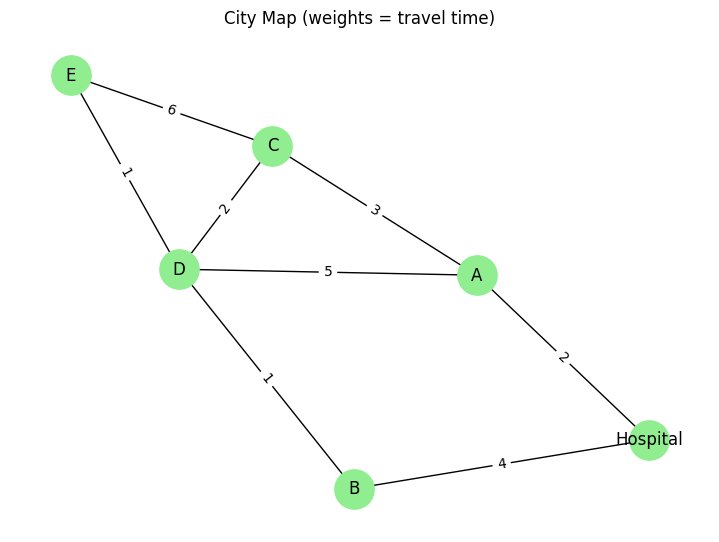

Saved -> images/dijkstra_graph.png


In [ ]:
# === Cell 3.2: Dijkstra example, profiling, visualization ===
# build adjacency list (positive weights)
adj = {
    "Hospital": [("A",2),("B",4)],
    "A": [("Hospital",2),("C",3),("D",5)],
    "B": [("Hospital",4),("D",1)],
    "C": [("A",3),("D",2),("E",6)],
    "D": [("A",5),("B",1),("C",2),("E",1)],
    "E": [("C",6),("D",1)]
}
res = mem_and_time(lambda: dijkstra(adj, "Hospital"))
dist, prev = dijkstra(adj, "Hospital")
print("Distances from Hospital:", dist)
print("Profiling -> time: {:.6f}s, mem: {:.3f} MB".format(res["time"], res["mem_mb"]))

# reconstruct and table
def path_from(prev, target):
    if prev[target] is None:
        return [target]
    p=[]
    cur=target
    while cur is not None:
        p.append(cur)
        cur = prev[cur]
    return p[::-1]

rows=[]
for n in adj:
    rows.append({"node": n, "distance": dist[n], "path": "->".join(path_from(prev, n))})
df = pd.DataFrame(rows)
df_to_csv_and_display(df, "tables/dijkstra_results.csv")

# visualize weighted graph
G = nx.Graph()
for u in adj:
    for v,w in adj[u]:
        if not G.has_edge(u,v):
            G.add_edge(u,v, weight=w)
pos = nx.spring_layout(G, seed=2)
edge_labels = nx.get_edge_attributes(G,'weight')
plt.figure(figsize=(7,5))
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=800)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("City Map (weights = travel time)")
plt.savefig("images/dijkstra_graph.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved -> images/dijkstra_graph.png")

In [ ]:
# === Cell 4.1: Union-Find (Disjoint Set) ===
class UnionFind:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def make_set(self, x):
        self.parent[x] = x
        self.rank[x] = 0

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        rx, ry = self.find(x), self.find(y)
        if rx == ry:
            return False
        if self.rank[rx] < self.rank[ry]:
            self.parent[rx] = ry
        else:
            self.parent[ry] = rx
            if self.rank[rx] == self.rank[ry]:
                self.rank[rx] += 1
        return True

Kruskal MST edges: [('A', 'B', 1), ('C', 'E', 2), ('A', 'C', 3), ('C', 'D', 4)]
Total MST cost: 10


,u,v,weight
0,A,B,1
1,C,E,2
2,A,C,3
3,C,D,4


Saved -> tables/kruskal_mst.csv


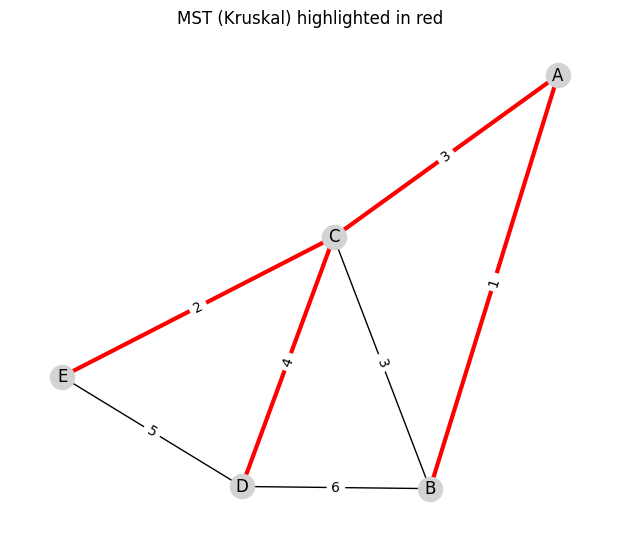

Saved -> images/kruskal_mst.png


In [ ]:
# === Cell 4.2: Kruskal's algorithm ===
def kruskal(nodes: List, edges: List[Tuple[float, str, str]]):
    """
    edges: list of (weight, u, v)
    returns (mst_edges, total_weight)
    """
    uf = UnionFind()
    for n in nodes:
        uf.make_set(n)
    mst = []
    total = 0
    # sort edges by weight
    edges_sorted = sorted(edges, key=lambda x: x[0])
    for w,u,v in edges_sorted:
        if uf.union(u,v):
            mst.append((u,v,w))
            total += w
    return mst, total

# example
nodes = ["A","B","C","D","E"]
edges = [
    (1,"A","B"),
    (3,"A","C"),
    (3,"B","C"),
    (6,"B","D"),
    (4,"C","D"),
    (2,"C","E"),
    (5,"D","E")
]
mst, total = kruskal(nodes, edges)
print("Kruskal MST edges:", mst)
print("Total MST cost:", total)

# Save table
df = pd.DataFrame([{"u":u,"v":v,"weight":w} for u,v,w in mst])
df_to_csv_and_display(df, "tables/kruskal_mst.csv")

# visualize MST on networkx
G = nx.Graph()
G.add_nodes_from(nodes)
for w,u,v in edges:
    G.add_edge(u,v,weight=w)
pos = nx.spring_layout(G, seed=3)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color='lightgray')
nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,w in mst], width=3, edge_color='red')
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.title("MST (Kruskal) highlighted in red")
plt.savefig("images/kruskal_mst.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved -> images/kruskal_mst.png")

In [ ]:
# === Cell 4.3: Prim's algorithm ===
def prim(adj: Dict, start):
    """
    adj: {u: [(v,w), ...], ...} undirected
    returns mst_edges, total_weight
    """
    visited = set()
    heap = []
    mst = []
    total = 0
    visited.add(start)
    for v,w in adj[start]:
        heapq.heappush(heap, (w, start, v))
    while heap:
        w,u,v = heapq.heappop(heap)
        if v in visited:
            continue
        visited.add(v)
        mst.append((u,v,w))
        total += w
        for to,wt in adj[v]:
            if to not in visited:
                heapq.heappush(heap, (wt, v, to))
    return mst, total

# example adjacency for same nodes
adj = {
    "A":[("B",1),("C",3)],
    "B":[("A",1),("C",3),("D",6)],
    "C":[("A",3),("B",3),("D",4),("E",2)],
    "D":[("B",6),("C",4),("E",5)],
    "E":[("C",2),("D",5)]
}
mst_prim, total_prim = prim(adj, "A")
print("Prim MST:", mst_prim)
print("Total cost (Prim):", total_prim)
df_to_csv_and_display(pd.DataFrame([{"u":u,"v":v,"weight":w} for u,v,w in mst_prim]), "tables/prim_mst.csv")

Prim MST: [('A', 'B', 1), ('A', 'C', 3), ('C', 'E', 2), ('C', 'D', 4)]
Total cost (Prim): 10


,u,v,weight
0,A,B,1
1,A,C,3
2,C,E,2
3,C,D,4


Saved -> tables/prim_mst.csv


from matplotlib import pyplot as plt
_df_0['weight'].plot(kind='hist', bins=20, title='weight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('u').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('v').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['weight'].plot(kind='line', figsize=(8, 4), title='weight')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['v'].value_counts()
    for x_label, grp in _df_4.groupby('u')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('u')
_ = plt.ylabel('v')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['u'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='weight', y='u', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['v'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='weight', y='v', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

,nodes,time_s,mem_mb
0,100,0.260851,0.003906
1,300,0.194460,0.000000


Saved -> tables/bfs_scale.csv


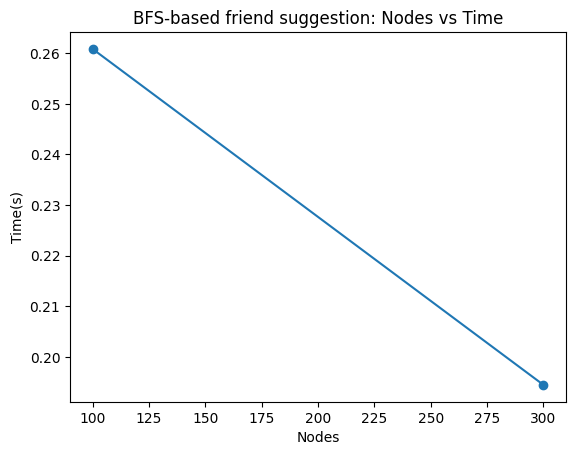

Saved -> images/bfs_scale.png


,V,time_s,mem_mb
0,50,0.324374,0.003906
1,100,0.052681,0.000000


Saved -> tables/bellman_scale.csv


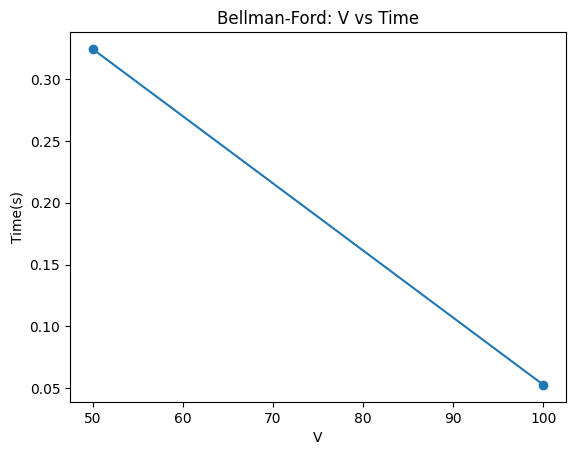

Saved -> images/bellman_scale.png


,V,time_s,mem_mb
0,100,0.103397,0.000000
1,300,0.101087,0.003906


Saved -> tables/dijkstra_scale.csv


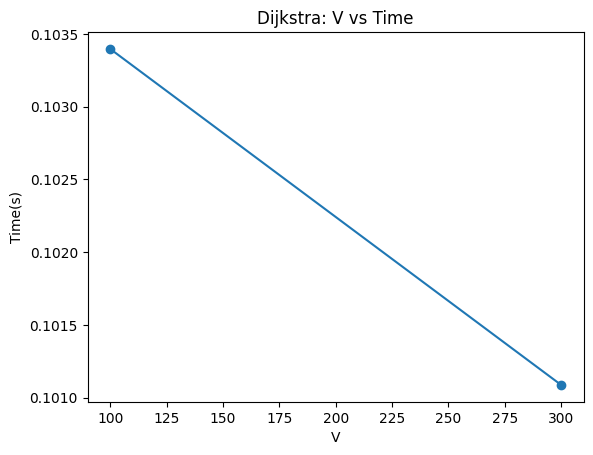

Saved -> images/dijkstra_scale.png


,V,time_s,mem_mb
0,50,0.099129,0.0
1,100,0.100974,0.0


Saved -> tables/mst_scale.csv


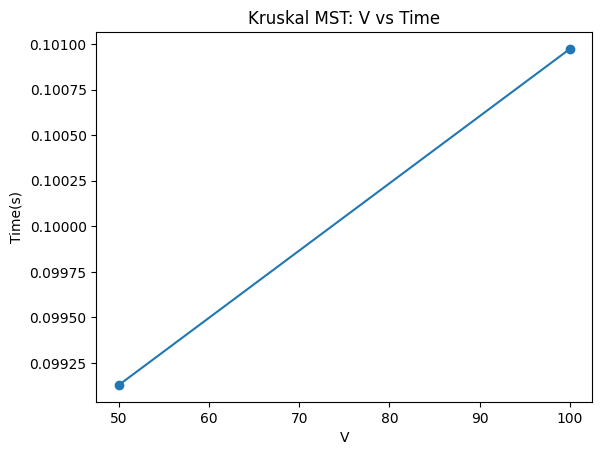

Saved -> images/mst_scale.png


In [ ]:
# === Cell 5.1: Quick profiling orchestration examples ===

# 1) BFS scale: vary number of nodes (create random sparse graph)
def bfs_profile_scale(ns=[100,500,1000,2000]):
    res=[]
    import random
    for n in ns:
        g = Graph()
        for i in range(n):
            g.add_node(i)
        # add approx 2n edges randomly (sparse)
        for _ in range(2*n):
            u = random.randrange(n); v = random.randrange(n)
            if u!=v:
                g.add_edge(u,v)
        t = mem_and_time(lambda: suggest_friends(g, 0))
        res.append({"nodes":n,"time_s":t["time"],"mem_mb":t["mem_mb"]})
    df = pd.DataFrame(res)
    df_to_csv_and_display(df, "tables/bfs_scale.csv")
    fig,ax = plt.subplots()
    ax.plot(df["nodes"], df["time_s"], marker='o'); ax.set_xlabel("Nodes"); ax.set_ylabel("Time(s)")
    ax.set_title("BFS-based friend suggestion: Nodes vs Time")
    save_and_show_plot(fig, "images/bfs_scale.png")

# 2) Bellman-Ford scale: vary V and edges
def bellman_scale(Vs=[50,100,200]):
    res=[]
    import random
    for v in Vs:
        nodes = list(range(v))
        edges=[]
        # create ~3v edges with small random weights (include some negative)
        for _ in range(3*v):
            u = random.choice(nodes); w = random.choice(nodes)
            if u!=w:
                wt = random.randint(-5,10)
                edges.append((u,w,wt))
        t = mem_and_time(lambda: bellman_ford(nodes, edges, 0))
        res.append({"V":v,"time_s":t["time"],"mem_mb":t["mem_mb"]})
    df=pd.DataFrame(res)
    df_to_csv_and_display(df,"tables/bellman_scale.csv")
    fig,ax = plt.subplots()
    ax.plot(df["V"], df["time_s"], marker='o'); ax.set_xlabel("V"); ax.set_ylabel("Time(s)")
    ax.set_title("Bellman-Ford: V vs Time")
    save_and_show_plot(fig,"images/bellman_scale.png")

# 3) Dijkstra scale: vary nodes for sparse graph
def dijkstra_scale(Vs=[100,300,600]):
    res=[]
    import random
    for v in Vs:
        adj={}
        for i in range(v):
            adj[i]=[]
        # create ~3v edges positive weights
        for _ in range(3*v):
            u=random.randrange(v); w=random.randrange(v)
            if u!=w:
                wt=random.randint(1,20)
                adj[u].append((w,wt))
                adj[w].append((u,wt))
        t = mem_and_time(lambda: dijkstra(adj, 0))
        res.append({"V":v,"time_s":t["time"],"mem_mb":t["mem_mb"]})
    df=pd.DataFrame(res)
    df_to_csv_and_display(df,"tables/dijkstra_scale.csv")
    fig,ax = plt.subplots()
    ax.plot(df["V"], df["time_s"], marker='o'); ax.set_xlabel("V"); ax.set_ylabel("Time(s)")
    ax.set_title("Dijkstra: V vs Time")
    save_and_show_plot(fig,"images/dijkstra_scale.png")

# 4) MST (Kruskal) scale: vary nodes and density
def mst_scale(Vs=[50,100,200]):
    res=[]
    import random
    for v in Vs:
        nodes=list(range(v))
        edges=[]
        # create dense ~5v edges
        for _ in range(5*v):
            u=random.randrange(v); w=random.randrange(v)
            if u!=w:
                edges.append((random.randint(1,20),u,w))
        t = mem_and_time(lambda: kruskal(nodes, edges))
        res.append({"V":v,"time_s":t["time"],"mem_mb":t["mem_mb"]})
    df=pd.DataFrame(res)
    df_to_csv_and_display(df,"tables/mst_scale.csv")
    fig,ax = plt.subplots()
    ax.plot(df["V"], df["time_s"], marker='o'); ax.set_xlabel("V"); ax.set_ylabel("Time(s)")
    ax.set_title("Kruskal MST: V vs Time")
    save_and_show_plot(fig,"images/mst_scale.png")

# Run small-scale experiments (reduce lists if runtime heavy)
bfs_profile_scale([100,300])
bellman_scale([50,100])
dijkstra_scale([100,300])
mst_scale([50,100])

In [ ]:
# === Cell 6: Summary and checklist ===
print("Images created in images/:")
for f in sorted(os.listdir("images")):
    print(" -", f)
print("\nTables created in tables/:")
for f in sorted(os.listdir("tables")):
    print(" -", f)

# Quick project summary CSV
summary = [
    {"Problem":"Social Network Friend Suggestion","Algorithm":"BFS/DFS","Complexity":"O(V+E)","Output":"tables/friend_suggestion_table.csv"},
    {"Problem":"Route Finding (Maps)","Algorithm":"Bellman-Ford","Complexity":"O(VE)","Output":"tables/bellmanford_results.csv"},
    {"Problem":"Emergency Response (Dijkstra)","Algorithm":"Dijkstra","Complexity":"O(E log V)","Output":"tables/dijkstra_results.csv"},
    {"Problem":"Network Cable Installation","Algorithm":"Kruskal/Prim","Complexity":"O(E log V)","Output":"tables/kruskal_mst.csv"}
]
pd.DataFrame(summary).to_csv("tables/project_summary_graphs.csv", index=False)
print("\nSaved project summary -> tables/project_summary_graphs.csv")

Images created in images/:
 - bellman_scale.png
 - bfs_scale.png
 - dijkstra_graph.png
 - dijkstra_scale.png
 - kruskal_mst.png
 - mst_scale.png
 - social_graph.png

Tables created in tables/:
 - bellman_scale.csv
 - bellmanford_results.csv
 - bfs_scale.csv
 - dijkstra_results.csv
 - dijkstra_scale.csv
 - friend_suggestion_table.csv
 - kruskal_mst.csv
 - mst_scale.csv
 - prim_mst.csv

Saved project summary -> tables/project_summary_graphs.csv


# Notes & Submission Checklist
- Run cells sequentially. First cell installs dependencies.
- Use smaller input sizes for initial testing (especially scaling experiments).
- Export images from images/ and tables from tables/ for your report and slides.
- Add a polished README.md and push `graph_realworld.ipynb`, images/, tables/, requirements.txt to GitHub.
- For presentation, include: problem description, algorithm idea, complexity, plots, and a short conclusion for each problem.
